# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000000)

In [12]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [13]:
len(y_val)

1409

In [14]:
(y_val == churn_decision).mean()

0.8034066713981547

In [18]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.512
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.766
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


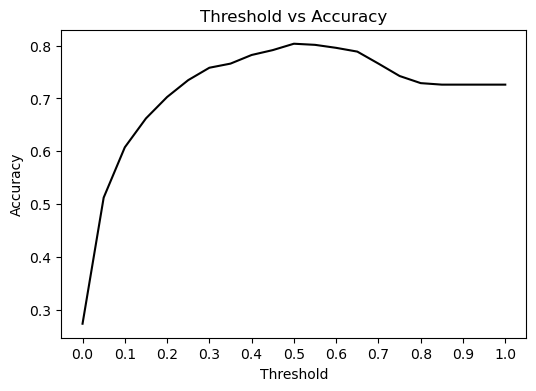

In [22]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, scores, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [23]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(y_val, y_pred>=0.5)

0.8034066713981547

In [28]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred>=t)
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.512
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.766
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


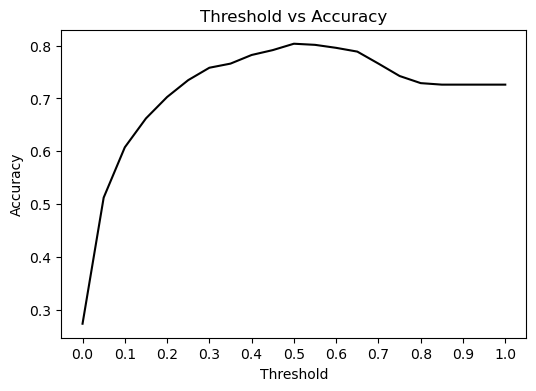

In [29]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, scores, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [31]:
from collections import Counter

In [32]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [33]:
Counter(y_pred >=0.5)

Counter({False: 1094, True: 315})

In [36]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [37]:
y_val.mean()

0.2739531582682754

In [35]:
1 - y_val.mean()

0.7260468417317246

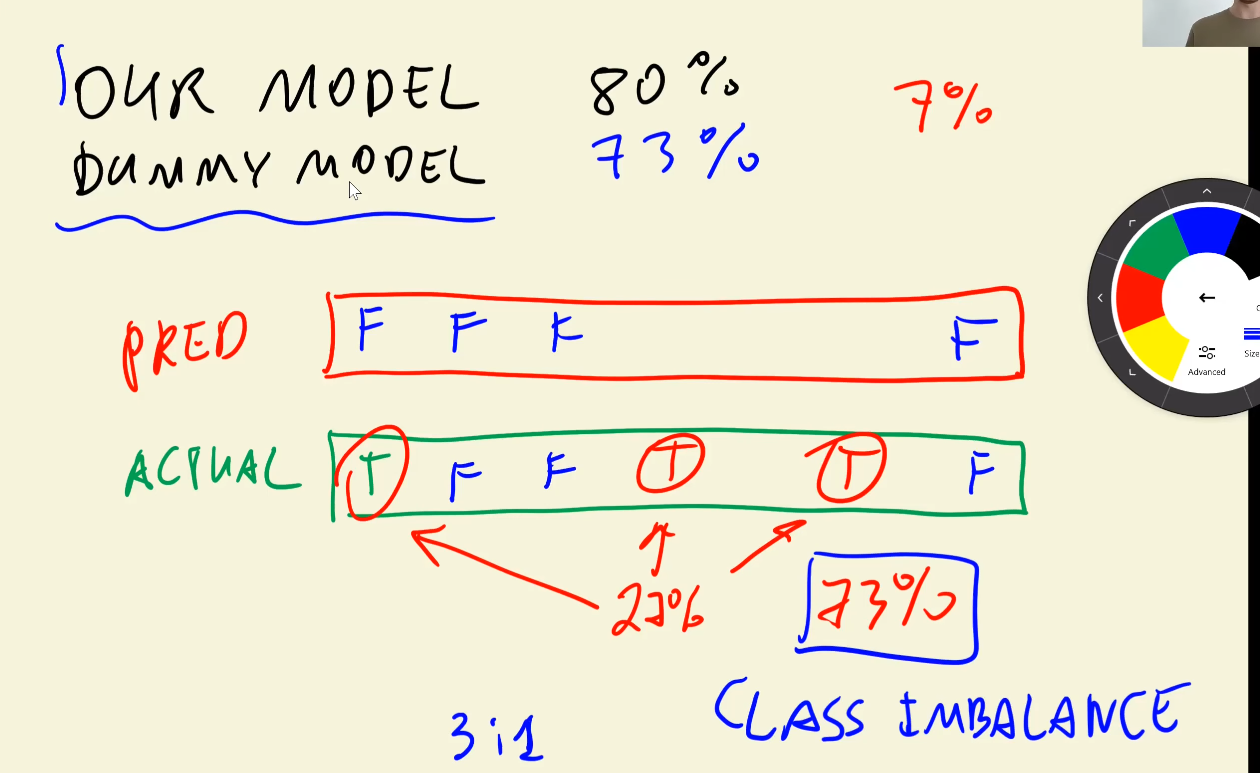

We can observe that there are significantly more non-churning customers than churning ones, with only 27% being churning customers and 73% being non-churning customers. This situation highlights a common challenge known as class imbalance, where one class has far more samples than the other.

In cases of class imbalance, the traditional accuracy metric can be misleading. For example, a dummy model that predicts the majority class for all samples can achieve a high accuracy simply by getting most of the samples right for the majority class. However, it will perform poorly in identifying the minority class (in this case, the churning customers), which is often more crucial to predict accurately.

To effectively address class imbalance and evaluate our model, we should consider alternative metrics such as:

 1. **Precision**: This metric measures the proportion of true positive predictions among all positive predictions. It is particularly useful when the cost of false positives is high.

 2. **Recall**: Recall measures the proportion of true positive predictions among all actual positive instances. It is valuable when the cost of false negatives is significant.

 3. **F1-Score**: The F1-Score is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives.

 4. **Area Under the Receiver Operating Characteristic Curve (AUC-ROC)**: The ROC curve plots the true positive rate against the false positive rate at various threshold settings. The AUC-ROC score assesses the classifier’s ability to distinguish between the positive and negative classes, making it particularly useful for imbalanced datasets.

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

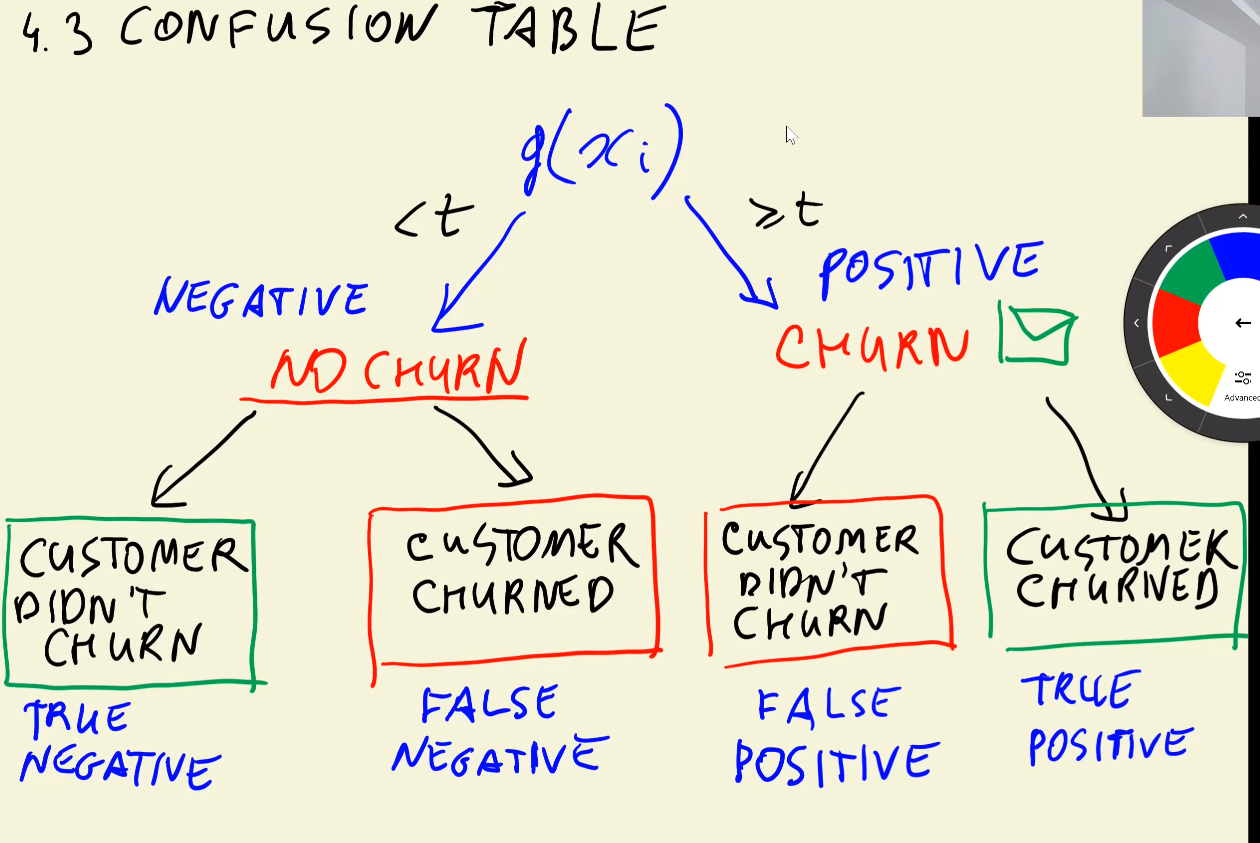

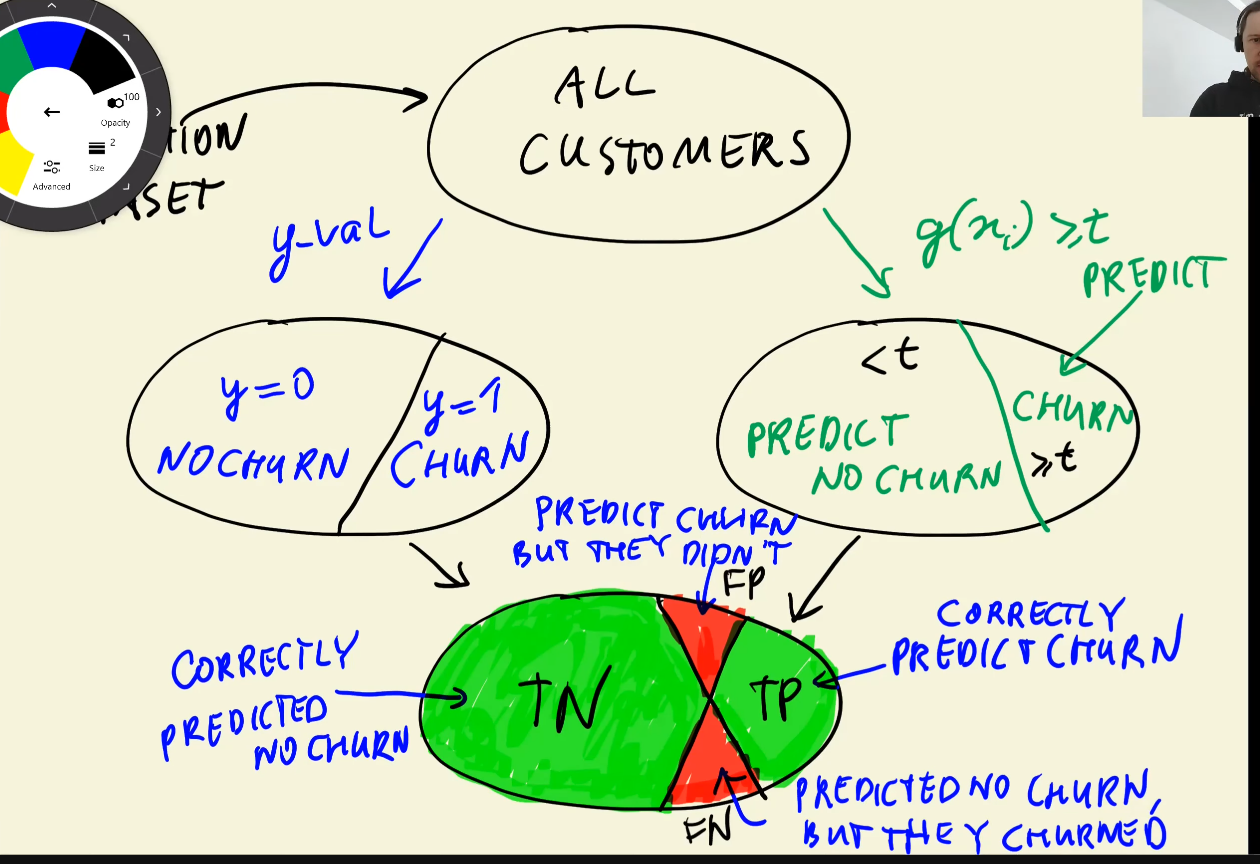

In [38]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [40]:
t = 0.5
predict_positive = (y_pred>=t)
predict_negative = (y_pred<t)

In [45]:
true_pos = (predict_positive & actual_positive).sum()
true_neg = (predict_negative & actual_negative).sum()

In [46]:
true_pos, true_neg

(212, 920)

In [47]:
false_pos = (predict_positive & actual_negative).sum()
false_neg = (predict_negative & actual_positive).sum()

In [48]:
false_pos, false_neg

(103, 174)

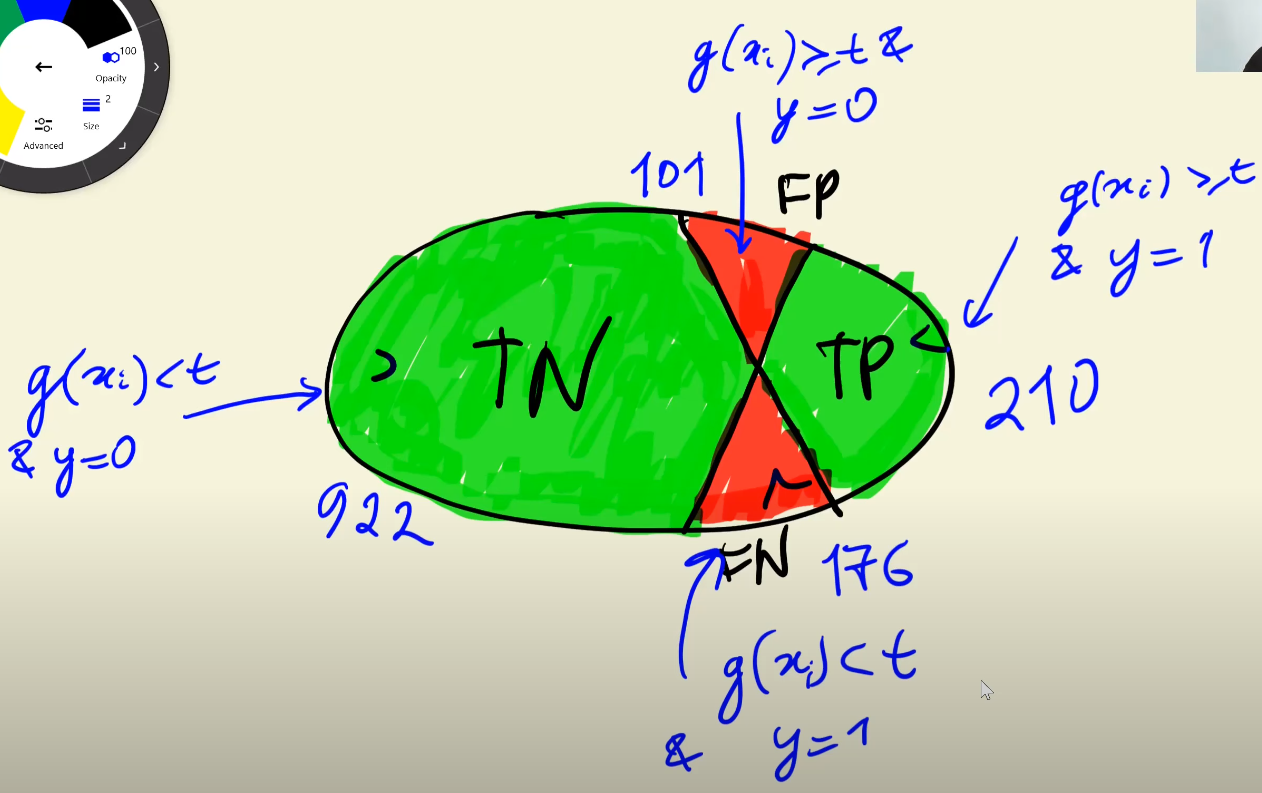

In [49]:
confusion_matrix = np.array([
    [true_neg, false_pos],
    [false_neg, true_pos]
])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [57]:
confusion_matrix_norm = (confusion_matrix / confusion_matrix.sum()).round(5)*100

In [58]:
Accuracy = confusion_matrix_norm[0][0] + confusion_matrix_norm[1][1] 

In [59]:
Accuracy

80.34100000000001

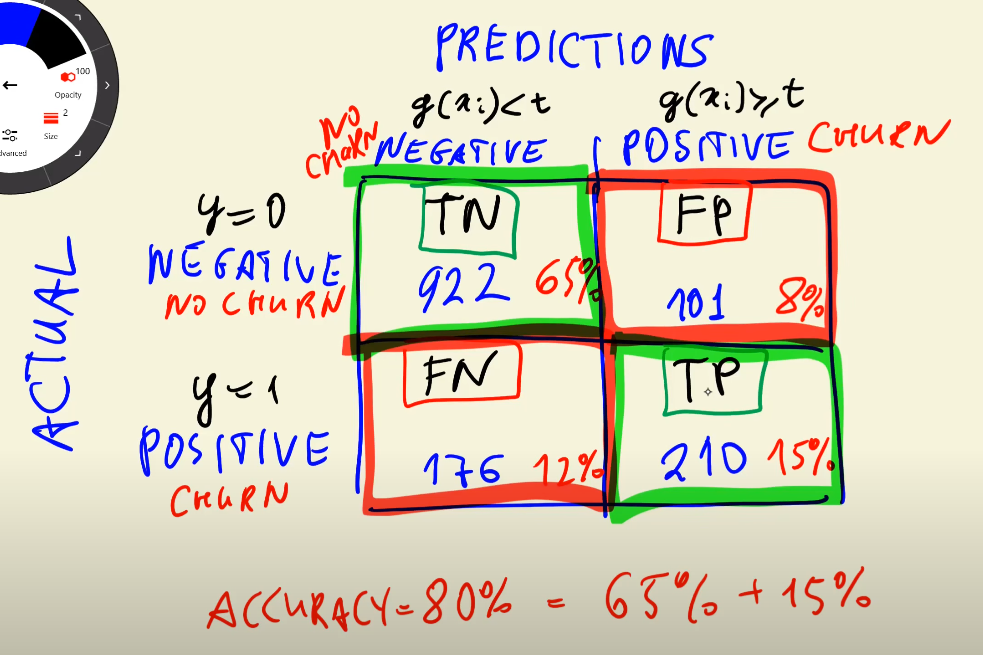